<a href="https://colab.research.google.com/github/Martinmbiro/Malaria/blob/main/02%20Malaria%20end%20to%20end.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Malaria End to end**
> In this notebook, I'll be using the modules I wrote in the preceding notebook `01 Malaria modular.ipynb` to finally train a model that classifies playing card images from the `kaggle`dataset linked [`here`](https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria)

In [ ]:
# to delete /content/helper_modules/ directory
# !rm -rf /content/helper_modules/
# !rm -rf /content/malaria/
# !rm -rf /content/models/

In [1]:
import torch, torchvision, zipfile, matplotlib.pyplot as plt, numpy as np, requests
from pathlib import Path

# for future reference, print versions
print(f'torch version: {torch.__version__}')
print(f'torchvison version: {torchvision.__version__}')

torch version: 2.6.0+cu124
torchvison version: 0.21.0+cu124


In [2]:
# set up device
if torch.cuda.is_available():
  device = 'cuda'
elif torch.backends.mps.is_available():
  device = 'mps'
else:
  device = 'cpu'

# print current device & GPU type
print(f'device: {device}')
if torch.cuda.is_available():
  print(f'GPU: {torch.cuda.get_device_name()}')

device: cuda
GPU: Tesla T4


### Get helper modules
> The function below makes use of the [`requests`](https://requests.readthedocs.io/) and [`zipfile`](https://docs.python.org/3/library/zipfile.html) modules to download and extract zipfile containing the custom helper modules from my GitHub repository linked [here](https://github.com/Martinmbiro/Card-classification/raw/refs/heads/main/helper%20modules/modules.zip)

> 📝 **Note**
+ The link passed to `requests.get()` should be the _raw_ link to the file on GitHub, otherwise it won't work.

In [5]:
%%time
# raw link to the zip folder
link = 'https://github.com/Martinmbiro/Malaria/raw/refs/heads/main/helper%20modules/modules.zip'

# make a get request to the link
r = requests.get(url=link, stream=True)

# check if response was successful
if r.status_code != 200:
  print(f'Unsuccessful Response! ERROR CODE: {r.status_code}\n.\nRe-run this cell to try again')
else:
  # create download folder
  HELPER_MODULES = Path('helper_modules')
  HELPER_MODULES.mkdir(parents=True, exist_ok=True)

  # specify zipfile directory
  MODULE_ZIP = HELPER_MODULES.joinpath('modules.zip')

  # download online file and write to 'downloads/modules.zip'
  with MODULE_ZIP.open(mode='wb') as f:
    for chunk in r.iter_content(chunk_size=200):
      f.write(chunk)

  # if valid zipfile, then extract
  if zipfile.is_zipfile(MODULE_ZIP):
    # extract
    with zipfile.ZipFile(file=MODULE_ZIP, mode='r') as zp:
      zp.extractall(path=HELPER_MODULES)
      print(f'{MODULE_ZIP.name} EXTRACTED TO: {Path.cwd().joinpath(HELPER_MODULES)}\n')
  else:
    print('A valid zip file was not downloaded.\nPlease check the link and retry!')

modules.zip EXTRACTED TO: /content/helper_modules

CPU times: user 13.3 ms, sys: 1.98 ms, total: 15.3 ms
Wall time: 694 ms


In [6]:
# import helper modules
from helper_modules import data_loader, model_builder, train_test, utils

### Load the data
> Here, I'll load the following from the `data_loader.py` module:
+ `train_dl` - A `Dataloader` for training `Dataset`
+ `test_dl` - A `Dataloader` for test `Dataset`
+ `y_true` - A `numpy.ndarray` of true class labels from test `Dataset`
+ `label_map` - A `dict` mapping class indices to class names

> 🔔 **Note**
+ This is quite a big dataset (at least 600MB) so it might take sometime to download and extract

In [7]:
%%time
# get dataloaders for train, test, validation & a label_map
train_dl, test_dl, val_dl, label_map = data_loader.get_dataloaders()

CPU times: user 1min 1s, sys: 12.6 s, total: 1min 13s
Wall time: 8min 53s


In [8]:
# length of train, test, validation dataloaders (no. batches)
len(train_dl), len(val_dl), len(test_dl)

(689, 130, 44)

In [9]:
# number of training, validation and test datasets samples
len(train_dl.dataset), len(val_dl.dataset), len(test_dl.dataset)

(22046, 4134, 1378)

#### Visualizing a random training batch
> Here, I'll take a random batch from the training `DataLoader` and visualize it

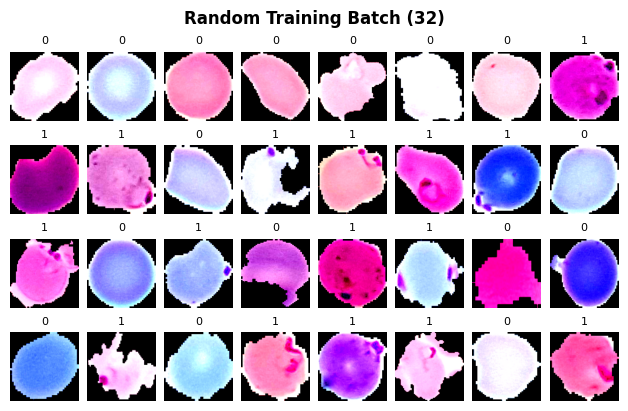

In [19]:
# visualize random training batch
x_batch, y_batch = next(iter(train_dl))
f, axs = plt.subplots(4, 8, figsize=(7.5,4), layout='compressed')

for i, ax in enumerate(axs.flat):
  img, lb = x_batch[i], y_batch[i]
  ax.imshow(img.permute(1,2,0).clamp(min=0, max=1))
  ax.set_title(lb.item(), fontsize=8)
  ax.axis(False)

# suptitle
f.suptitle('Random Training Batch (32)', weight='black')
plt.show()

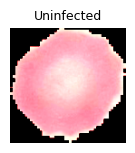

In [20]:
# visualize a random image from the training dataset
img, lb = test_dl.dataset[np.random.randint(len(test_dl.dataset))]

plt.figure(figsize=(1.5,1.5))
plt.axis(False)
plt.title(label_map[lb], fontsize=9)
plt.imshow(img.permute(1,2,0).clamp(min=0, max=1))
plt.show()

### Get model, optimizer, loss function
> Here, we'll define a model, optimize and loss function with the help of the `model_builder.py` module

In [15]:
%%time
# get model, optimizer, and loss function
model, opt, loss_fn = model_builder.get_model(device)

CPU times: user 188 ms, sys: 15.9 ms, total: 204 ms
Wall time: 452 ms


#### Visualize structure of neural network
> We'll do this using the [`torchinfo`](https://github.com/TylerYep/torchinfo) library

In [16]:
# install torchinfo
!pip install torchinfo
from torchinfo import summary

In [17]:
# visualize model structure
summary(model, input_size=(1, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 2]                    --
├─Conv2d: 1-1                            [1, 64, 64, 64]           9,408
├─BatchNorm2d: 1-2                       [1, 64, 64, 64]           128
├─ReLU: 1-3                              [1, 64, 64, 64]           --
├─MaxPool2d: 1-4                         [1, 64, 32, 32]           --
├─Sequential: 1-5                        [1, 64, 32, 32]           --
│    └─BasicBlock: 2-1                   [1, 64, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 64, 32, 32]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 32, 32]           128
│    │    └─Identity: 3-3                [1, 64, 32, 32]           --
│    │    └─ReLU: 3-4                    [1, 64, 32, 32]           --
│    │    └─Identity: 3-5                [1, 64, 32, 32]           --
│    │    └─Conv2d: 3-6                  [1, 64, 32, 32]           36,864
│ 

### Early stopping
> 💎 **Pro Tip**

> [Early stopping](https://www.linkedin.com/advice/1/what-benefits-drawbacks-early-stopping#:~:text=Early%20stopping%20is%20a%20form,to%20increase%20or%20stops%20improving.) is a mechanism of stopping training when the validation loss stops improving; with a view to preventing _overfitting_ on the training data
+ Here, I'll declare an object of `EarlyStopping` class from `utils.py`

In [ ]:
# earlystopping object
est = utils.EarlyStopping(score_type='metric', patience=3)

### Model training
> Here, we'll define an optimization loop to train and evaluate the model
+ We'll make use of the `train_batches` and `test_batches` functions defined in `train_test.py` module

> 📝 **Note**
+ Since this is a medical problem and we want to reduce the number of _false negatives_ we'll focus on the model with the highest `recall` metric
+ Higher `recall` score ensures that there's less _false negatives_
+ However, it's good to note that the training data was balanced for both classes, due to how I sampled images from both classes. See the **Load the data** section on `01 Malaria modular.ipynb` notebook

In [ ]:
%%time
# lists to keep progress of training / testing values
train_loss, val_loss, train_rec, val_rec, train_acc, val_acc, ep_list = [],\
    [], [], [], [], [], [],
# epochs
epochs = 20

for ep in range(1, epochs+1):
  ep_list.append(ep)

  # train
  tr_loss, tr_acc, tr_rec = train_test.train_batches(model, train_dl, opt, loss_fn, device)
  # append values to list
  train_loss.append(tr_loss), train_acc.append(tr_acc), train_rec.append(tr_rec)

  # test
  vl_loss, vl_acc, vl_rec = train_test.test_batches(model, val_dl, loss_fn, device)
  val_loss.append(vl_loss), val_acc.append(vl_acc), val_rec.append(vl_rec)

  # early stopping
  est(model=model, ep=ep, ts_score=vl_rec) # evaluate for each epoch
  if est.stop_early:
    break

  # if ep%2 == 0:
  print(f'Epoch: {ep}\n----------')
  print(f'Train Loss: {tr_loss:.3f} | Test Loss: {vl_loss:.3f}')
  print(f'Train Accuracy: {tr_acc:.3f} | Test Accuracy: {vl_acc:.3f}')
  print(f'Train Recall Score: {tr_rec:.3f} | Test Recall Score: {vl_rec:.3f}\n')

# print best results
print(f'STOPPED | Best Epoch: {est.best_epoch} | Best Recall Score: {est.best_score:.3f}')

Epoch: 1
----------
Train Loss: 0.137 | Test Loss: 0.130
Train Accuracy: 0.953 | Test Accuracy: 0.956
Train Recall Score: 0.944 | Test Recall Score: 0.927

Epoch: 2
----------
Train Loss: 0.094 | Test Loss: 0.114
Train Accuracy: 0.967 | Test Accuracy: 0.961
Train Recall Score: 0.960 | Test Recall Score: 0.941

Epoch: 3
----------
Train Loss: 0.075 | Test Loss: 0.128
Train Accuracy: 0.974 | Test Accuracy: 0.959
Train Recall Score: 0.968 | Test Recall Score: 0.937

Epoch: 4
----------
Train Loss: 0.063 | Test Loss: 0.147
Train Accuracy: 0.977 | Test Accuracy: 0.956
Train Recall Score: 0.971 | Test Recall Score: 0.943

Epoch: 5
----------
Train Loss: 0.052 | Test Loss: 0.174
Train Accuracy: 0.981 | Test Accuracy: 0.949
Train Recall Score: 0.976 | Test Recall Score: 0.910

Epoch: 6
----------
Train Loss: 0.047 | Test Loss: 0.152
Train Accuracy: 0.982 | Test Accuracy: 0.961
Train Recall Score: 0.977 | Test Recall Score: 0.947

Epoch: 7
----------
Train Loss: 0.036 | Test Loss: 0.156
Train A

In [ ]:
# overwrite the model parameters with best parameters from earlystopping
model.load_state_dict(est.best_state_dict)

<All keys matched successfully>

#### Get `y_true`, `y_pred` and `y_proba`
+ I'll make use of the `true_preds_proba` function defined in `train_test.py` module



In [ ]:
%%time
y_true, y_pred, y_proba = train_test.true_preds_proba(model, test_dl, device)

# confirm the size of both
y_true.shape, y_pred.shape, y_proba.shape

CPU times: user 406 ms, sys: 125 ms, total: 531 ms
Wall time: 3.14 s


((1378,), (1378,), (1378, 2))

### Model evaluation
> Here, I'll evaluate the model by plotting results from the optimization loop, as well as evaluating it on basis of classification metrics  

> ✋ **Info**
+ I'll be using [`scikit-learn`](https://scikit-learn.org/stable/index.html) [classification metrics](https://scikit-learn.org/stable/api/sklearn.metrics.html#classification-metrics)

#### Plot optimization results
+ I'll use the `plot_train_results` function defined in `utils.py` module

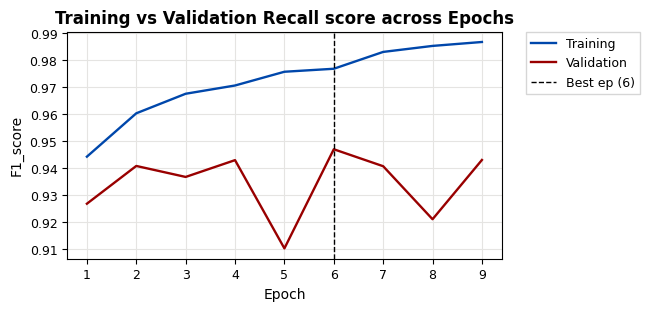

In [ ]:
# training vs validation f1_scores
utils.plot_train_results(ep_list=ep_list, train_score=train_rec, test_score=val_rec,
                   ylabel='F1_score',
                   title='Training vs Validation Recall score across Epochs',
                   best_epoch=est.best_epoch)

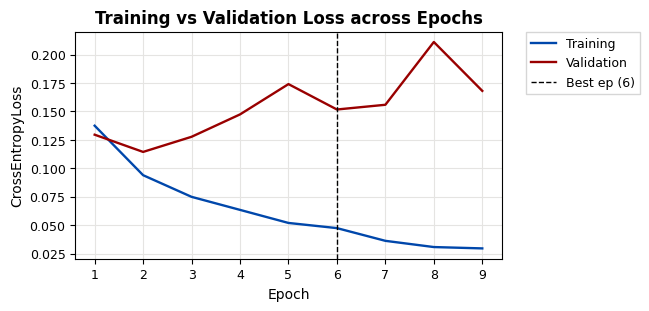

In [ ]:
# training vs validation loss
utils.plot_train_results(ep_list=ep_list, train_score=train_loss, test_score=val_loss,
                   ylabel='CrossEntropyLoss',
                   title='Training vs Validation Loss across Epochs',
                   best_epoch=est.best_epoch)

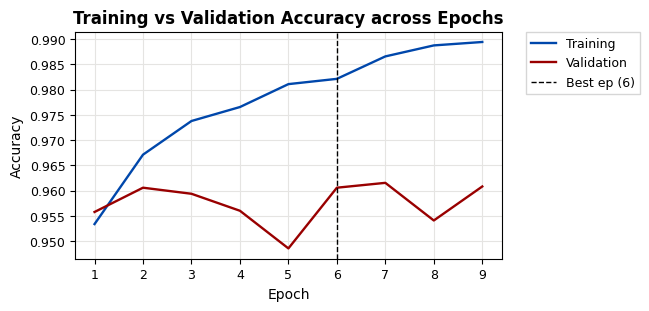

In [ ]:
# training vs validation accuracy
utils.plot_train_results(ep_list=ep_list, train_score=train_acc, test_score=val_acc,
                   ylabel='Accuracy',
                   title='Training vs Validation Accuracy across Epochs',
                   best_epoch=est.best_epoch)

#### [`accuracy`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)

In [ ]:
from sklearn.metrics import accuracy_score

# calculate
acc = accuracy_score(y_true=y_true, y_pred=y_pred)
# print
print(f'Model accuracy: {acc:.4f}')

Model accuracy: 0.9717


#### [`recall_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#recall-score)

In [ ]:
from sklearn.metrics import recall_score

# calculate
acc = recall_score(y_true=y_true, y_pred=y_pred)
# print
print(f'Model recall: {acc:.4f}')

Model recall: 0.9711


#### [`f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score)

In [ ]:
from sklearn.metrics import f1_score

# calculate
f1 = f1_score(y_true=y_true,
              y_pred=y_pred)
# print
print(f'F1_score: {f1:.4f}')

F1_score: 0.9718


#### [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report)

In [ ]:
from sklearn.metrics import classification_report

# calculate
cr = classification_report(y_true=y_true, y_pred=y_pred)
# print
print(cr)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       685
           1       0.97      0.97      0.97       693

    accuracy                           0.97      1378
   macro avg       0.97      0.97      0.97      1378
weighted avg       0.97      0.97      0.97      1378



#### [`roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)

In [ ]:
from sklearn.metrics import roc_auc_score
# calculate
ras = roc_auc_score(y_true=y_true,
                    y_score=y_proba[:,1])
# print
print(f'roc_auc_score: {ras:.3f}')

roc_auc_score: 0.992


#### [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay)
+ `plot_confusion_matrix` function from the `utils.py` module will help plot a `confusion_matrix`

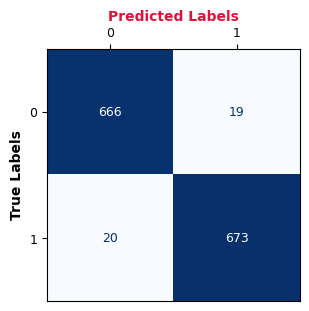

In [ ]:
utils.plot_confusion_matrix(y_true=y_true, y_pred=y_pred)

### Save model
+ Here, I'll make use of the `save_model` function from the `utils.py` module

In [18]:
# make a parent directory
PARENT = Path('models')
PARENT.mkdir(parents=True, exist_ok=True)

# model directory
MODEL_PATH = PARENT.joinpath('malaria.pth')

# view model path
print(f'Model path: {MODEL_PATH}')

Model path: models/malaria.pth


In [ ]:
# save
utils.save_model(model=model, path=MODEL_PATH)

MODEL'S state_dict SAVED TO: models/malaria.pth


#### Load saved model
+ Here, we'll use the `load_model` function defined in `utils.py`

In [21]:
# first, create an object of the model class
loaded_model, _, _ = model_builder.get_model(device)

# load
utils.load_model(model=loaded_model, path=MODEL_PATH)

### Make inference
> Here, we'll make inference:
+ On a single random data sample
+ On multiple `12` random data samples

#### Make inference on single image
> Using `make_single_inference` in `utils.py` module

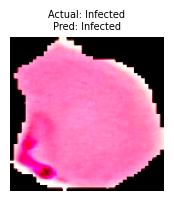

In [26]:
# make inference on single random image from test set
utils.make_single_inference(loaded_model, test_dl.dataset, label_map, device)

#### Making inference on multiple images
> Using `make_multiple_inference` in `utils.py` module

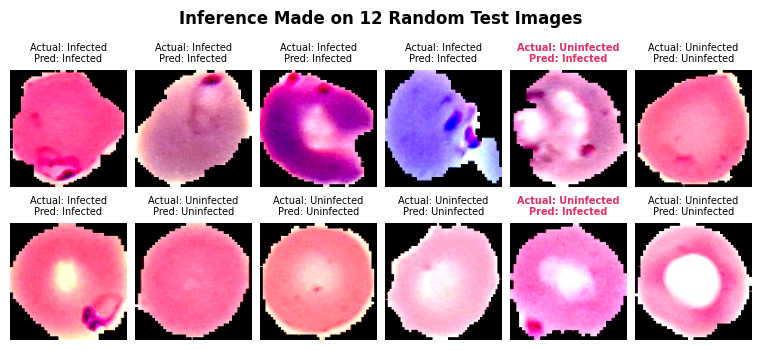

In [28]:
# make inference on 12 random images from test set
utils.make_multiple_inference(loaded_model, test_dl.dataset, label_map, device)

### Conclusion

> 📈  **Results**  
> We were able to achieve the following when the model was evaluated on the _test dataset_ (on a scale of `0` -> `1`):
+ A weighted `precision`, `recall` and `f1_score` of `0.97`
+ An overall model `accuracy` of `0.9717`
+ An overall `roc_auc_score` of `0.992`

> Until next time, happy coding! 👋